```bash
## TO RUN THIS NOTEBOOK FROM THE TERMINAL
$ jupyter nbconvert --to script PlayGround.ipynb
$ python PlayGround.py
```

In [1]:
import numpy as np
import pandas as pd
from importlib import reload

import matplotlib.pyplot as plt
plt.style.use("matplotlib.mplstyle")

In [2]:
import matplotlib
from pathlib import Path
for path in Path("../../../common/fonts/").rglob('*.otf'):
    matplotlib.font_manager.fontManager.addfont(str(path))

In [3]:
from model import pipeline, utils
reload(pipeline)

<module 'model.pipeline' from '/home/hdd/Dropbox/work-Proj/Proj-UV-GNR-ML/code/model/pipeline.py'>

In [ ]:
class LoadData(pipeline.Adapter):
    """ Load and train/test split the data """
    def __init__(self, resample = False):
        self.testdf = None
        self.traindf = None
        # if train test split should be performed for each line
        self.resample = resample

    def add_classes(self, data):
        data = data.assign(coating = data[['lobe', 'full', 'other']].idxmax(axis=1))
        data = data.assign(coatingId = data.coating.replace(data.coating.unique(),
                                                    range(len(data.coating.unique()))))
        data = data.set_index('name')
        self.sayf("Add coating classes: {}", list(data.coating.unique()))
        return data
    
    def calc_train_test(self, data):
        while True:
            # Sample 6 data points for testing
            testIds = data[data.imp == 0].dropna().id.sample(n=6)

            # Separate test and training data
            self.testdf = data[data.imp == 0].loc[lambda df: df.id.isin(testIds)]
            self.traindf = data.loc[lambda df: ~df.id.isin(testIds)].dropna()
            if list(self.testdf.coating).count('lobe') == 2 and len(self.testdf.coating.unique()) == 3:
                break

        self.sayf("Test IDs: {}", list(testIds))
        self.sayf("Test classes: {}", list(self.testdf.coating))

    def Process(self, csv):
        if self.testdf is None:
            data = pd.read_csv(csv)
            data = self.add_classes(data)
            self.calc_train_test(data)
        elif self.resample:
            self.calc_train_test(data)

        payload = pipeline.Payload()
        payload.Tr = self.traindf.copy()
        payload.Ts = self.testdf.copy()
        return payload
    
class ImputedData(pipeline.Adapter):
    """ Select imputed data as the training data """
    def Process(self, X):
        X.Tr = X.Tr[X.Tr.imp > 0]
        return X
    
class ObservedData(pipeline.Adapter):
    """ Select observed data as the training data """
    def Process(self, X):
        X.Tr = X.Tr[X.Tr.imp == 0]
        X.cv = 3
        return X
    
class SetYCol(pipeline.Adapter):
    def __init__(self, ycol):
        self.ycol = ycol
    def Process(self, pl):
        pl.yCol = self.ycol
        print("'%s'" %pl.yCol, end = " ")
        return pl

class DropCol(pipeline.Adapter):
    def __init__(self, col):
        self.col = col
    def Process(self, pl):
        pl.Tr = pl.Tr.drop(self.col, axis=1)
        pl.Ts = pl.Ts.drop(self.col, axis=1)
        if pl.xCols is not None and self.col in pl.xCols:
            pl.xCols = pl.xCols.drop(self.col)
        return pl

class Set(pipeline.Adapter):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def __repr__(self):
        return "Set: " + " ".join([kw for kw in self.kwargs])

    def Process(self, pl):
        for kw in self.kwargs:
            if hasattr(pl, kw):
                setattr(pl, kw, self.kwargs[kw])
            else:
                ValueError("Unrecongnized set payload attribute '%s'" %kw)
        self.sayf("{}", self.kwargs)
        return pl

In [ ]:
from model import features
class AggregateFeatures(pipeline.Adapter):
    """ Calculate difference and inverse difference features. """
    def __init__(self, show=True):
        self.show = show
    def Process(self, pl):
        oldfeats = pl.Tr.columns
        pl.Tr = features.Differences(pl.Tr)
        pl.Tr = features.InverseDifferences(pl.Tr)
        pl.Ts = features.Differences(pl.Ts)
        pl.Ts = features.InverseDifferences(pl.Ts)
        newfeats = pl.Tr.columns.difference(oldfeats)
        if self.show:
            self.sayf("Added {} new features.", len(newfeats))
            self.sayf("{}", list(newfeats))
        return pl

In [ ]:
from sklearn.preprocessing import StandardScaler
from model import utils

class NonCollinearFeatures(pipeline.Adapter):
    """ Set xCols based on features that do no create multicollinearity. """
    def __init__(self, keepCols = [], ignoreCols = [], vif_cutoff = 10, show=True):
        self.keepCols = keepCols
        self.ignoreCols = ignoreCols
        self.vif_cut = vif_cutoff
        self.passedCols = None
        self.failedCols = None
        self.show = show

    def find_noncollinear_features(self, df):
        """ Try to add columns one by one to dataframe without creating multicollinearity.
            Return the list of features that passed the VIF check.
            Use standard scaled values to reduce VIF.
        """

        candidate = []
        collinear = []

        passed = self.keepCols.copy()

        for col in df.columns:
            if col in passed:
                continue
            try:
                vif = utils.calc_vif(df[passed + [col]]).drop(col, axis=1)
            except:
                continue
            if vif.iloc[0, 0] < self.vif_cut:
                passed.append(col)
            else:
                candidate.append(col)
                collinear.append(vif.columns[0])

        self.failedCols = pd.DataFrame({'linearColumn': collinear}, index=candidate)
        self.passedCols = utils.calc_vif(df[passed])
        
        return self.passedCols.columns

    def Process(self, pl):
        df = pl.Tr.drop(self.ignoreCols, axis=1)
        sclr = StandardScaler().fit(df)
        sdf = pd.DataFrame(sclr.transform(df), index=df.index, columns=df.columns)
        pl.xCols = self.find_noncollinear_features(sdf)
        self.sayf("Selected {} features.", len(pl.xCols))
        if self.show:
            self.sayf("{}", list(pl.xCols))
        return pl

In [ ]:
class AllValidFeatures(pipeline.Adapter):
    def __init__(self, ignoreCols=[], show=False):
        self.ignore = ignoreCols
        self.show = show

    def Process(self, pl):
        pl.xCols = pl.Tr.columns.drop(self.ignore)
        self.sayf("Selected {} features.", len(pl.xCols))
        if self.show:
            self.sayf("{}", list(pl.xCols))
        return pl

In [ ]:
from sklearn.preprocessing import StandardScaler

class ScaleX(pipeline.Adapter):
    """ Standard scale the xCols of the datasets. """
    def __init__(self, scaler=StandardScaler, allColumns = False):
        self.scaler = scaler
        self.allCols = allColumns
        
    def __repr__(self):
        return "ScaleX: " + utils.nice_name(self.scaler)

    def Process(self, pl):
        if self.allCols:
            tCols = pl.Tr.select_dtypes(include=np.number).columns
            if pl.yCol in tCols:
                tCols = tCols.drop(pl.yCol)
            self.sayf("Scaled all columns.")
        else:
            tCols = pl.xCols
            self.sayf("Scaled xCols, non xCols are unchanged.")

        # fit on the training set only
        pl.xsclr = self.scaler().fit(pl.Tr[tCols])
        
        # transform training
        dft = pl.xsclr.transform(pl.Tr[tCols])
        dft = pd.DataFrame(dft, index=pl.Tr.index, columns=tCols)
        pl.Tr.update(dft)
        
        # transform test
        dft = pl.xsclr.transform(pl.Ts[tCols])
        dft = pd.DataFrame(dft, index=pl.Ts.index, columns=tCols)
        pl.Ts.update(dft)
        
        return pl

class UnscaleX(pipeline.Adapter):
    """ Unscale the xCols of the training dataset. """
    def __init__(self, allColumns = False):
        self.allCols = allColumns
    def Process(self, pl):
        if pl.xsclr is None: return pl
        if self.allCols:
            tCols = pl.Tr.select_dtypes(include=np.number).columns
            if pl.yCol in tCols:
                tCols = tCols.drop(pl.yCol)

        else:
            tCols = pl.xCols
        dft = pl.xsclr.inverse_transform(pl.Tr[tCols])
        dft = pd.DataFrame(dft, index=pl.Tr.index, columns=tCols)
        pl.Tr.update(dft)
        dft = pl.xsclr.inverse_transform(pl.Ts[tCols])
        dft = pd.DataFrame(dft, index=pl.Ts.index, columns=tCols)
        pl.Ts.update(dft)
        return pl

In [606]:
class PlotFrequency(pipeline.Adapter):
    def __init__(self, col, saveAs=None):
        self.saveAs = saveAs
        self.col = col

    def _plot(self, df):
        fig, ax = plt.subplots(figsize=(4, 3))
        df[self.col].hist(bins=20, ax = ax, label = "N = %d" %df.shape[0])
        # ax.set_xticks(np.arange(df[self.qcol].min(),
        #                         df[self.qcol].max()+1))
        ax.set(xlabel = self.col, ylabel = "Count")
        ax.legend()
        if self.saveAs:
            plt.savefig(self.saveAs)
            plt.close()
        else:
            plt.show()

    def Process(self, pl):
        self._plot(pl.Tr)
        return pl
    
class PlotPerturbation(pipeline.Adapter):
    def __init__(self, orig, count = 5, saveAs=None, scaled=False):
        self.saveAs = saveAs
        self.orig = orig
        self.scld = scaled
        self.count = count

    def _plot(self, df):
        df1 = self.orig.select_dtypes(np.number)
        df2 = df.select_dtypes(np.number)
        # choose the common columns
        xcols = np.intersect1d(df1.columns, df2.columns, True)

        if self.scld:
            sclr = StandardScaler().fit(df1[xcols])
            df1 = pd.DataFrame(sclr.transform(df1[xcols]), columns=xcols)
            df2 = pd.DataFrame(sclr.transform(df2[xcols]), columns=xcols)

        n = 0
        fig = plt.figure(figsize=(7, 6))

        for i in range(self.count):
            col1 = xcols[i]
            for j in range(i+1, self.count):
                n += 1
                col2 = xcols[j]
                ax = fig.add_subplot(4, 5, n)
                ax.plot(df2[col1], df2[col2], 'r.', alpha=0.7, label="new")
                ax.plot(df1[col1], df1[col2], 'kx', label="orig")
                ax.set(xlabel = col1, ylabel=col2)

        plt.tight_layout()
        if self.saveAs:
            plt.savefig(self.saveAs)
            plt.close()
        else:
            plt.show()

    def Process(self, pl):
        self._plot(pl.Tr)
        return pl

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE

from model import utils

class AugmentImb(pipeline.Adapter):
    """ Augment the training dataset. """
    def __init__(self, sampler_instance, show=True):
        self.overSampler = sampler_instance
        self.show = show

    def __repr__(self):
        return "AugmentImb: " + utils.nice_name(self.overSampler)

    def Process(self, pl):
        shp = pl.Tr.shape
        X = pl.Tr.drop(pl.yCol, axis=1)
        y = pl.Tr[pl.yCol]
        Xs, ys = self.overSampler.fit_resample(X, y)
        pl.Tr = pd.concat([Xs, ys], axis=1)
        self.sayf("Old shape: {}, New shape: {}", shp, pl.Tr.shape)
        return pl

In [577]:
from sklearn.preprocessing import StandardScaler

class AugmentByQuality(pipeline.Adapter):
    """ Augment the training dataset.
        F : Frequency parameter, higher = more rows added
        scale : Perturbation parameter, lower = sample more similar to originals
    """
    def __init__(self, F = 2, scale = 0.2, qcol = "quality"):
        assert F <= 5, "Too high value of K will make a dataset invalid"
        self.f = F
        self.qcol = qcol
        self.scl = scale

    def __repr__(self):
        return "AugmentByQuality: F=%d scale=%.2f" %(self.f, self.scl)
    
    def PlotPerturbation(self, orig, new, scaled=False):
        df1 = orig.select_dtypes(np.number)
        df2 = new.select_dtypes(np.number)
        # choose the common columns
        xcols = np.intersect1d(df1.columns, df2.columns, True)

        if scaled:
            sclr = StandardScaler().fit(df1[xcols])
            df1 = pd.DataFrame(sclr.transform(df1[xcols]), columns=xcols)
            df2 = pd.DataFrame(sclr.transform(df2[xcols]), columns=xcols)

        n = 0
        fig = plt.figure(figsize=(8, 6))

        for i in range(5):
            col1 = xcols[i]
            for j in range(i+1, 5):
                n += 1
                col2 = xcols[j]
                ax = fig.add_subplot(4, 5, n)
                ax.plot(df2[col1], df2[col2], 'r.', alpha=0.7, label="new")
                ax.plot(df1[col1], df1[col2], 'kx', label="orig")
                ax.set(xlabel = col1, ylabel=col2)
                if n%20 == 0:
                    plt.tight_layout()
                    plt.show()
                    n = 0
                    fig = plt.figure(figsize=(8, 6))

        plt.tight_layout()
        plt.show()

    def Process(self, pl):
        shp = pl.Tr.shape        
        df = pl.Tr[pl.xCols] # data subset to augment
        
        sclr = StandardScaler().fit(df)
        dft = sclr.transform(df) # perform augmentation in the scaled range
        
        C = pl.Tr.shape[0] # current row count
        N = 0 # count of newly added rows
        for i in range(pl.Tr.shape[0]):
            # for each existing row
            row = pl.Tr.iloc[i:i+1].copy()
            q = row.iloc[0,][self.qcol] # the quality value
            stdev = self.scl / q # higher quality = lower stdev.
            rep = int(q ** self.f / 5) # higher quality = more frequent
            
            for j in range(1, rep+1):
                # sample around this row `rep` times
                N += 1
                sample = np.random.normal(loc=dft[i:i+1, :], scale=stdev)
                sample = sclr.inverse_transform(sample) # unscale new values
                sdf = pd.DataFrame(sample,
                                   columns = df.columns,
                                   index = [C + N])
                row.index = [C + N] # needed for alignment
                row.update(sdf) # update the old row with new values
                pl.Tr = pd.concat([pl.Tr, row], axis=0) # append row
                
        self.sayf("Old shape: {}, New shape: {}", shp, pl.Tr.shape)
        return pl

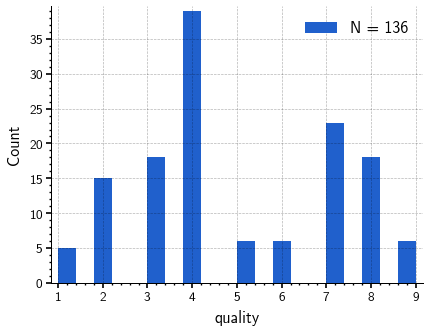

In [601]:
pl = loader.Process(None)
ag = AugmentByQuality()._newline(0)
im = AugmentImb(ADASYN())._newline(0)
ag.PlotFrequency(pl.Tr)

pl.xCols = pl.Tr.columns.drop(ignoreXCols + ['coatingId', 'coating'])
pl.yCol = 'coating'

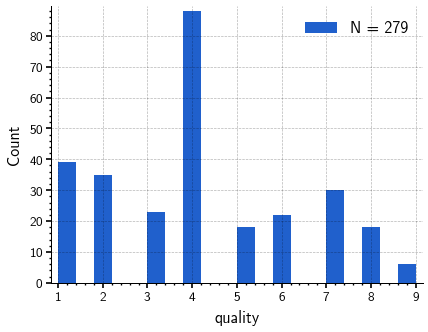

In [602]:
nl = im.Process(pl)
ag.PlotFrequency(nl.Tr)

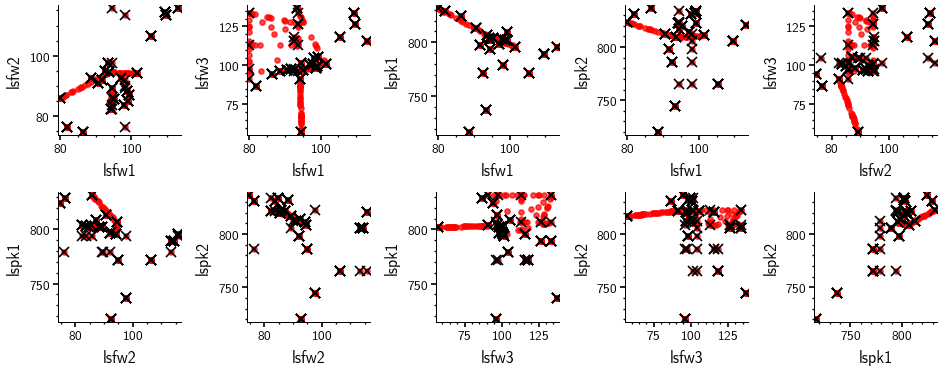

In [603]:
ag.PlotPerturbation(loader.traindf[pl.xCols], nl.Tr)

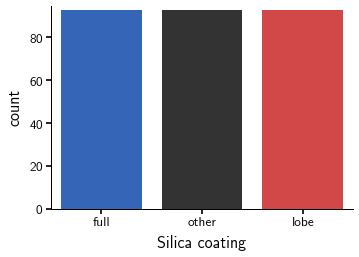

In [604]:
import seaborn as sns
fig, ax = plt.subplots()
sns.countplot(x=nl.Tr.coating, ax = ax)
plt.minorticks_off()
plt.xlabel("Silica coating")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

class SetModel(pipeline.Adapter):
    """ Augment the training dataset. """
    def __init__(self, model_instance):
        self.model = model_instance

    def __repr__(self):
        return "SetModel: " + utils.nice_name(self.model)

    def Process(self, pl):
        # fit the model to data
        X = pl.Tr[pl.xCols]
        y = pl.Tr[pl.yCol]
        self.model.fit(X, y)
        pl.model = self.model
        return pl

In [ ]:
import warnings
from sklearn.feature_selection import RFECV

class SelectFeaturesRFE(pipeline.Adapter):
    """ Augment the training dataset. """
    def __init__(self, show=True):
        self.show = show
        self.best = None

    def Process(self, pl):
        clf = RFECV(pl.model, cv=pl.cv, n_jobs = -1, scoring = pl.scoring,
                   min_features_to_select=5)

        X = pl.Tr[pl.xCols]
        y = pl.Tr[pl.yCol]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.best = clf.fit(X, y)
        
        pl.xCols = X.columns[self.best.support_]
        self.sayf("RFE {}-fold CV with {} selected {} features.",
                  pl.cv, pl.model, len(pl.xCols))
        if self.show:
            self.sayf("{}", list(pl.xCols))
        return pl

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

class SearchHyperParams(pipeline.Adapter):
    """ Augment the training dataset. """
    def __init__(self, algorithms_dict, show=False):
        self.show = show
        self.algorithms = algorithms_dict
        self.best = None

    def Process(self, pl):
        name = utils.nice_name(pl.model)
        if name not in self.algorithms:
            self.sayf("Skipped {}: not defined in algorithms_dict", name)
            return pl
        else:
            grid, hyp = self.algorithms[name]
        
        if grid:
            print("running grid search", end = " ... ")
            clf = GridSearchCV(pl.model, hyp, cv=pl.cv, scoring=pl.scoring,
                               n_jobs = -1)
        else:
            print("running randomized search", end = " ... ")
            clf = RandomizedSearchCV(pl.model, hyp, cv=pl.cv, scoring=pl.scoring,
                                     n_iter = 1000, n_jobs = -1)

        X = pl.Tr[pl.xCols]
        y = pl.Tr[pl.yCol]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.best = clf.fit(X, y)
        
        pl.model = self.best.best_estimator_
        self.sayf("{}-fold CV HyperParam search for {}.\nBest score: {}",
                  pl.cv, pl.model, self.best.best_score_)
        if self.show:
            self.sayf("Best parameters: {}", self.best.best_params_)
        return pl

In [342]:
import matplotlib.pyplot as plt
from model import plotlib, utils
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

class TestPerformance(pipeline.Adapter):
    """ Test the performance of a classifier. """
    def __init__(self, savePref=None, show=True):
        self.savePref = savePref
        self.show = show
        
    def _plot_confusion(self, y, p, pl):
        if not self.savePref:
            return
        cf = confusion_matrix(y, p)
        f1 = classification_report(y, p, output_dict = True, zero_division=0)
        stat = "\n\nWeighted f1-score: %0.3f" %f1['weighted avg']['f1-score']
        
        name = utils.nice_name(pl.model)

        # Plot
        plotlib.make_confusion_matrix(cf, categories = pl.model.classes_,
                                      title = name,
                                      sum_stats = False,
                                      other_stat = stat)
        plt.minorticks_off()
        plt.tight_layout()
        if self.savePref:
            path = "%s.pipeline%02d.png" %(self.savePref, self.lineId)
            plt.savefig(path)
            print("Save OK:", path)
        if self.show:
            plt.show()
        else:
            plt.close()
            
    def _calc_score(self, y, p, pl):
        f1 = classification_report(y, p, output_dict = True, zero_division=0)
        
        criteria = [
            ('100% accuracy', f1['weighted avg']['f1-score'] == 1),
            ('5/6 accuracy',  f1['weighted avg']['f1-score'] > 5/6),
        ]
        
        # per class accuracy
        for c in ['lobe', 'full', 'other']:
            r = "100%% accuracy on %s" %c
            v = False
            if c in f1:
                v = f1[c]['f1-score'] >= 0.99
            criteria.append((r, v))
            
            r = "80%% accuracy on %s" %c
            v = False
            if c in f1:
                v = f1[c]['f1-score'] >= 0.80
            criteria.append((r, v))
            
        # make data frame of the results
        pl.score_report = pd.DataFrame({ 'result': [i[1] for i in criteria] },
                                    index = [i[0] for i in criteria])
        pl.score = pl.score_report.sum().values[0]
        pl.stats['wt_f1'] = f1['weighted avg']['f1-score']
        pl.stats['acc_f1'] = f1['accuracy']
        return pl

    def Process(self, pl):
        X = pl.Ts[pl.xCols]
        y = pl.Ts[pl.yCol]
        p = pl.model.predict(X)
        pl = self._calc_score(y, p, pl)
        self.sayf("SCORE: {}", pl.score)
        if self.show or pl.score > 0:
            print()
            print(pl.score_report)
            self.sayf("{}", classification_report(y, p, zero_division=0))
            # # Numeric ycol needed for AUC
            # if pl.yCol in pl.Ts.select_dtypes(include=['int64','float64']):
            #     self.sayf("AUC = {}", roc_auc_score(y, p, multi_class='ovo'))
        self._plot_confusion(y, p, pl)
        return pl

In [ ]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import kernels, GaussianProcessClassifier

# list of tuples of algorithm, if_gridsearch, and hyperparam space
algorithms = {
    'gbtree': (False, dict(
        gamma = np.linspace(0, 100, num=10),
        max_depth = [1, 2, 5, 6, 7, 8, 9],
        learning_rate = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2],
        n_estimators = range(1, 10),
        subsample = np.linspace(0.1, 0.9, num=5),
        objective = ['multi:softmax', 'multi:softprob'],
        reg_alpha = [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
        reg_lambda = [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
    )),
    'KNeighborsClassifier': (True, dict(
        # The optimal value depends on the nature of the problem
        leaf_size = np.linspace(1, 100, num = 10).astype(int),
        
        # Number of neighbors to use
        n_neighbors = np.linspace(1, 10, num = 10).astype(int),
        
        # Weight function used in prediction
        weights = ['uniform', 'distance'],
        
        # Algorithm used to compute the nearest neighbors
        algorithm= ['auto', 'ball_tree', 'kd_tree', 'brute'],
        
        # manhattan_distance (l1) or euclidean_distance (l2)
        p=[1, 2],
        
        # Parallel processing
        n_jobs = [-1],
    )),
    'SVC': (True, dict(
        C=np.linspace(0.001, 1, num=10),
        kernel=['rbf', 'poly', 'linear'],
    )),
    'RandomForestClassifier': (False, dict(
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(1, 200, num = 10)],

        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(1, 10)] + [None],

        # Minimum number of samples required to split a node
        min_samples_split = [1, 2],

        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4],

        # Method of selecting samples for training each tree
        bootstrap = [True, False],
        
        # Parallel processing
        n_jobs = [-1],
    )),
    'GaussianProcessClassifier': (False, dict(
        kernel = [kernels.RBF(), kernels.RBF() + kernels.WhiteKernel()],
        n_restarts_optimizer = [1, 2, 5],
        max_iter_predict = [10, 100, 1000],
        warm_start = [True, False],
        multi_class = ['one_vs_rest', 'one_vs_one'],
        n_jobs = [-1],
    ))
}

In [345]:
ignoreXCols = ['imp', 'id', 'quality', 'lobe', 'full', 'other', 'coatingId']
loader = LoadData()
loader.Execute("../Data/imputed_data.mice.csv")

 -- LoadData() ... 
	 Add coating classes: ['full', 'other', 'lobe']
	 Test IDs: [15, 30, 16, 26, 20, 22]
	 Test classes: ['other', 'lobe', 'full', 'full', 'lobe', 'full']



In [ ]:
grid = [
    loader,
    (
        ObservedData(),
        ImputedData()
    ),
    SetYCol('coatingId'),
    Set(scoring='f1_weighted'),
    DropCol('coating'),
    AugmentByQuality(F=2, scale=0.3, qcol='quality'),
    (
        None,
        AugmentImb(RandomOverSampler()),
        AugmentImb(BorderlineSMOTE()),
        AugmentImb(SMOTE()),
        AugmentImb(ADASYN()),
    ),
    AggregateFeatures(show=False),
    (
        AllValidFeatures(ignoreCols=ignoreXCols),
        NonCollinearFeatures(keepCols=['teosVolPct', 'teosVolume'],
                             ignoreCols=ignoreXCols, show=False),
    ),
    ScaleX(allColumns=False),
    (
        # SetModel(RandomForestClassifier()),
        SetModel(DecisionTreeClassifier()),
    ),
    (
        None,
        SelectFeaturesRFE(show=True)
    ),
    (
        # SetModel(XGBClassifier()),
        SetModel(KNeighborsClassifier()),
        # SetModel(SVC()),
        # SetModel(GaussianProcessClassifier()),
        # SetModel(RandomForestClassifier()),
    ),
    SearchHyperParams(algorithms),
    TestPerformance(show=True)
]

In [ ]:
pipe = pipeline.GridLine(grid)
pipe.Execute("../Data/imputed_data.mice.csv")

In [ ]:
res = pipe.Summarize()
print(res)
try:
    res.to_csv("gridline_results.csv")
except:
    input("Please close the excel file if open and press enter ...")
    res.to_csv("gridline_results.csv")
    print("Saved")

In [ ]:
class get_ipython:
    def system(*args):
        pass

```bash
## RUN THIS NOTEBOOK FROM THE TERMINAL
$ jupyter nbconvert --to script PlayGround.ipynb
$ python PlayGround.py
```